In [269]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
from matplotlib.backends.backend_pdf import PdfPages
import sys
import random
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import sys
sys.path.append('/home/almhatre/data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#internal
from AGNclustering.kde import weighted_gaussian_kde
import AGNclustering.projected_correlation_functions as w
import AGNclustering.wppi_projected_correlation_functions as wz
import AGNclustering.BASS_randoms as rand
from AGNclustering.utils import wp_d1d2,wp_dd
from AGNclustering.wppi_utils import wppi_d1d2,wppi_dd,ratio_error,control_var,force_distributionmatch, control_mult_var

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)

In [4]:
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN

In [5]:
agnt.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

Using sensitivity maps for 70 month survey


Set MJD-OBS to 53355.002572 from DATE-OBS.
Set MJD-END to 55469.117384 from DATE-END'. [astropy.wcs.wcs]


number of randoms: 55602


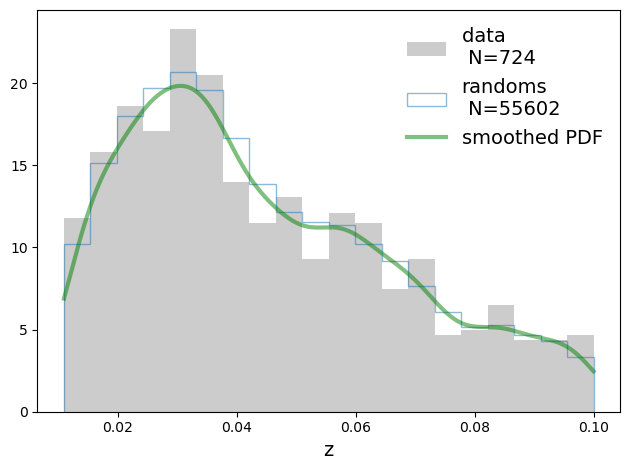

In [6]:
arand = rand.genrand(agn,100,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
                     data_path=data_directory,plot=True,plot_filename=None)

#100: 100X randoms as AGN

number of randoms: 887041


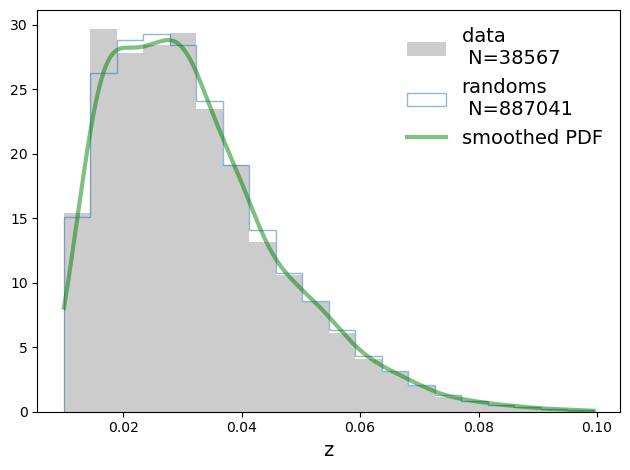

In [7]:
grandt = rand.genrand(gal,23,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=False,\
                     plot=True,plot_filename=None)

# exclude galactic plane:
gal = gal[(gal['b']<-8) | (gal['b']>8)]
grand = grandt[(grandt['b']<-8) | (grandt['b']>8)]

In [310]:
AGN_highmass = agn[(agn['Mbh']>7.81) ]
AGN_lowmass = agn[(agn['Mbh']<=7.81)]
nonzero=agn['Mbh']!=0
agnmass=agn[nonzero]
agnmass=agnmass[(agnmass['log_Ms']>8)]

# bins for wppi/wprp
ratiobins=np.arange(0,13,1,dtype=float)
ratiobins[0]=0.01
ratiopibins=np.arange(1,13,1)

pimax=40

# Different pibins
pibins = np.logspace(0,np.log10(40),6, dtype=int)
linpibins = np.arange(1,41,1)

# Different rp bins
binsmod = np.logspace(0,np.log10(40),6,dtype=int)
binsmod = binsmod.astype(dtype=float)
binsmod = np.insert(binsmod, 0, 0.1)

linbins = np.arange(0,41,1, dtype=float)
linbins[0] = 0.01

nbins = 10
bins = np.logspace(-1, np.log10(40), nbins + 1)


# z space bins
stmin=np.min(agnmass['z'])
stmax=np.max(agnmass['z'])
increm=(0.100001-stmin)/9
zbins=np.arange(stmin,stmax+increm,increm)


stmin=np.min(agnmass['z'])
stmax=np.max(agnmass['z'])
increm=(0.100001-stmin)/5
zbinsmod=np.arange(stmin,stmax+increm,increm)

# stellar mass bin
stmin=np.min(agnmass['log_Ms'][agnmass['log_Ms']>8])
stmax=np.max(agnmass['log_Ms'][agnmass['log_Ms']>8])
increm=(stmax-stmin)/5
msbinsmod=np.arange(stmin,stmax+increm,increm)


increm=(stmax-stmin)/9
msbins=np.arange(stmin,stmax+increm,increm)
# percentage of each mass bin
percentile=33


# pdf=PdfPages('/home/almhatre/data/Plots/Binned Blackhole Clustering controlling for redshift and stellar mass.pdf')
# pdf.close()

In [311]:
%autoreload 2
agnlowmass,agnmidmass,agnhighmass=control_var(agn=agnmass,bins=zbins,control='z',var='Mbh',percentile=percentile)

In [312]:
forced_agnhighmass,forced_agnlowmass=force_distributionmatch(agnhighmass=agnhighmass,agnlowmass=agnlowmass,var='log_Ms',bins=msbins)

In [313]:
upper, mid, lower = control_mult_var(agn=agnmass,bins1=zbins,bins2=msbins,control1='z',control2='log_Ms',var='Mbh',percentile=percentile)


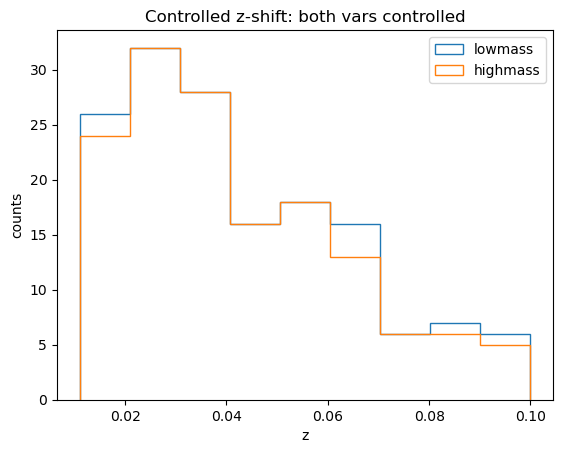

In [314]:
plt.hist(lower['z'],bins=zbins, histtype='step',label='lowmass')
plt.hist(upper['z'],bins=zbins, histtype='step',label='highmass')
graph=plt.title('Controlled z-shift: both vars controlled')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()


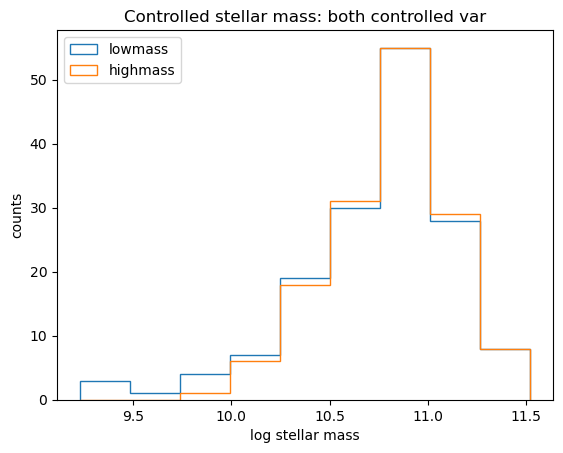

In [315]:
plt.hist(lower['log_Ms'],bins=msbins, histtype='step',label='lowmass')
plt.hist(upper['log_Ms'],bins=msbins, histtype='step',label='highmass')
graph=plt.title('Controlled stellar mass: both controlled var')
plt.xlabel('log stellar mass')
plt.ylabel('counts')
plt.legend()


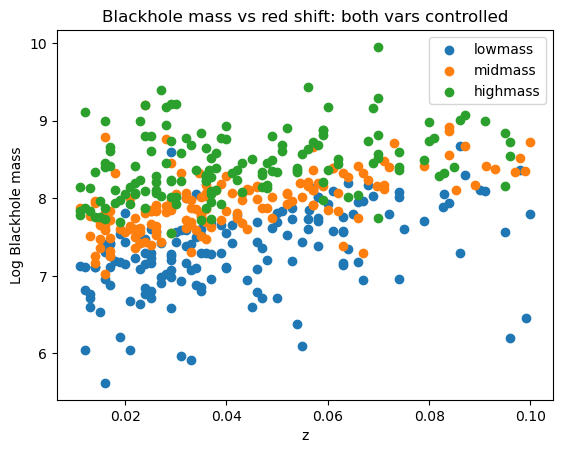

In [316]:
plt.scatter(lower['z'],lower['Mbh'],label='lowmass')
plt.scatter(mid['z'],mid['Mbh'],label="midmass")
plt.scatter(upper['z'],upper['Mbh'],label='highmass')
plt.xlabel('z')
plt.ylabel('Log Blackhole mass')
plt.title('Blackhole mass vs red shift: both vars controlled')
plt.legend()


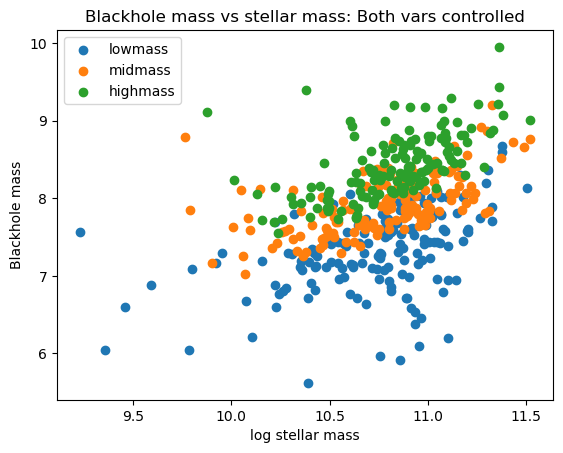

In [317]:
plt.scatter(lower['log_Ms'],lower['Mbh'],label='lowmass')
plt.scatter(mid['log_Ms'],mid['Mbh'],label="midmass")
plt.scatter(upper['log_Ms'],upper['Mbh'],label='highmass')
plt.xlabel('log stellar mass')
plt.ylabel('Blackhole mass')
plt.title('Blackhole mass vs stellar mass: Both vars controlled')
plt.legend()


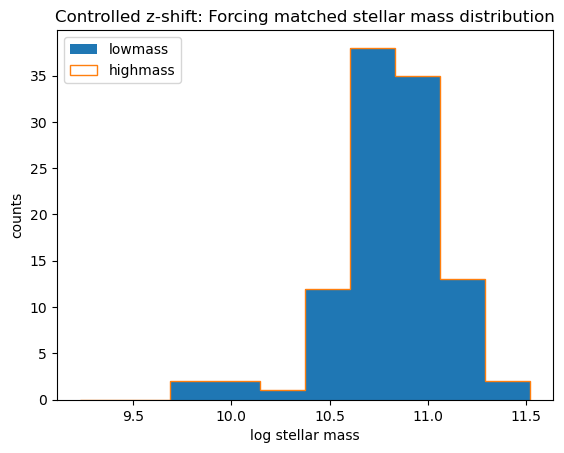

In [13]:
plt.hist(forced_agnlowmass['log_Ms'],bins=msbins, histtype='bar',label='lowmass')
plt.hist(forced_agnhighmass['log_Ms'],bins=msbins, histtype='step',label='highmass')
graph=plt.title('Controlled z-shift: Forcing matched stellar mass distribution')
plt.xlabel('log stellar mass')
plt.ylabel('counts')
plt.legend()

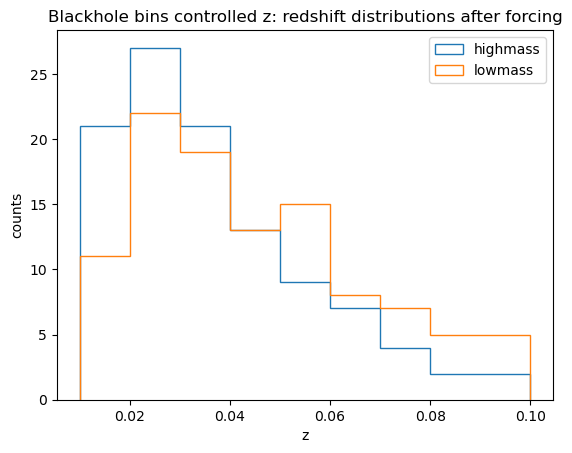

In [28]:
plt.hist(forced_agnhighmass['z'],bins=zbins,histtype='step',label='highmass')
plt.hist(forced_agnlowmass['z'],bins=zbins,histtype='step',label='lowmass')
graph=plt.title('Blackhole bins controlled z: redshift distributions after forcing')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()

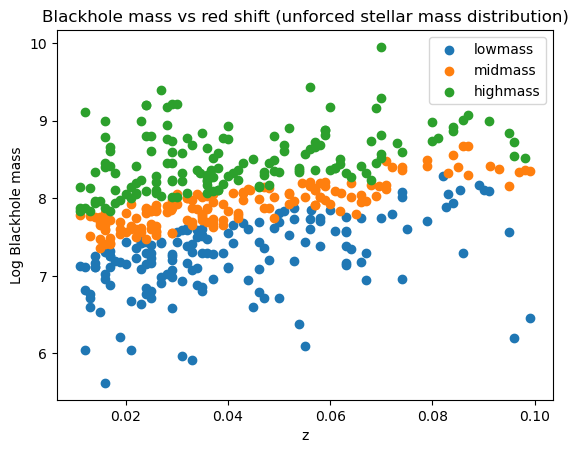

In [29]:
plt.scatter(agnlowmass['z'],agnlowmass['Mbh'],label='lowmass')
plt.scatter(agnmidmass['z'],agnmidmass['Mbh'],label="midmass")
plt.scatter(agnhighmass['z'],agnhighmass['Mbh'],label='highmass')
plt.xlabel('z')
plt.ylabel('Log Blackhole mass')
plt.title('Blackhole mass vs red shift (unforced stellar mass distribution)')
plt.legend()

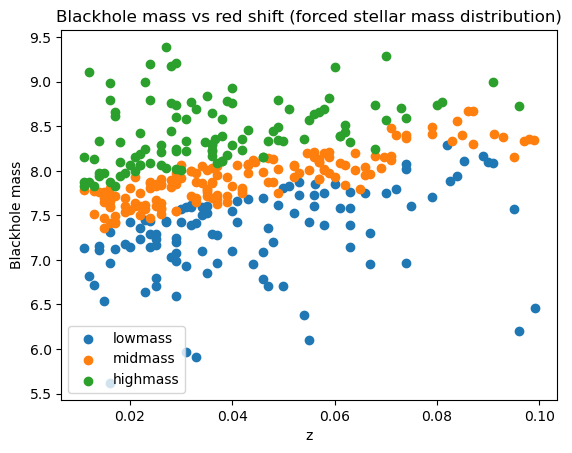

In [30]:
plt.scatter(forced_agnlowmass['z'],forced_agnlowmass['Mbh'],label='lowmass')
plt.scatter(agnmidmass['z'],agnmidmass['Mbh'],label="midmass")
plt.scatter(forced_agnhighmass['z'],forced_agnhighmass['Mbh'],label='highmass')
plt.xlabel('z')
plt.ylabel('Blackhole mass')
plt.title('Blackhole mass vs red shift (forced stellar mass distribution)')
plt.legend()

In [14]:
agnstellarlowmass,agnstellarmidmass,agnstellarhighmass = control_var(agn=agnmass,bins=msbins,control='log_Ms',var='Mbh',percentile=percentile)

In [15]:
forced_agnstellarhighmass,forced_agnstellarlowmass=force_distributionmatch(agnhighmass=agnstellarhighmass,agnlowmass=agnstellarlowmass,var='z',bins=zbins)


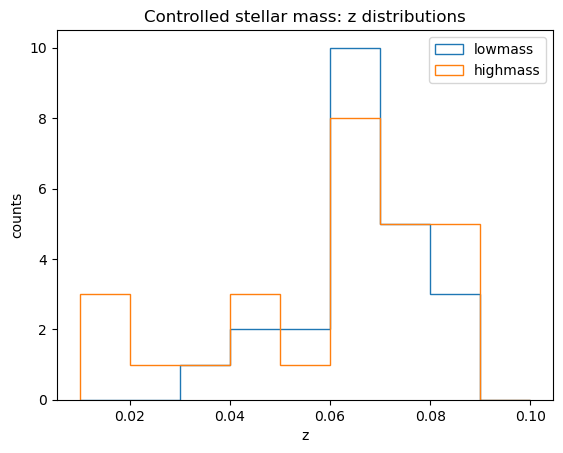

In [89]:
plt.hist(upper['z'],bins=zbins,histtype='step',label='lowmass')
plt.hist(lower['z'],bins=zbins,histtype='step',label='highmass')
graph=plt.title('Controlled stellar mass: z distributions')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()

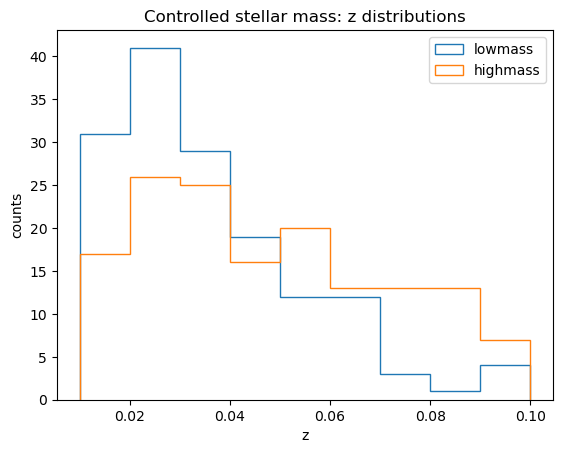

In [18]:
plt.hist(agnstellarlowmass['z'],bins=zbins,histtype='step',label='lowmass')
plt.hist(agnstellarhighmass['z'],bins=zbins,histtype='step',label='highmass')
graph=plt.title('Controlled stellar mass: z distributions')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()

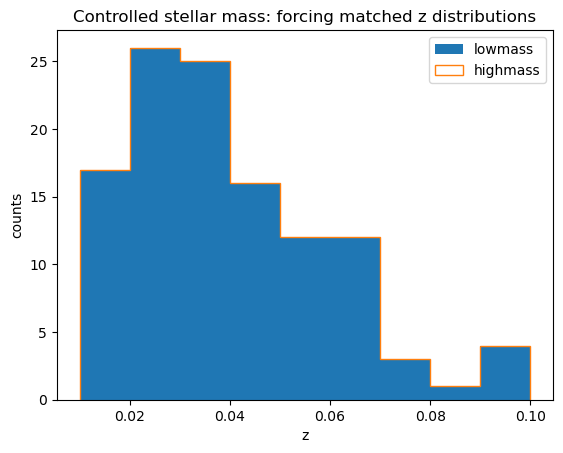

In [19]:
plt.hist(forced_agnstellarlowmass['z'],bins=zbins,histtype='bar',label='lowmass')
plt.hist(forced_agnstellarhighmass['z'],bins=zbins,histtype='step',label='highmass')
graph=plt.title('Controlled stellar mass: forcing matched z distributions')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()

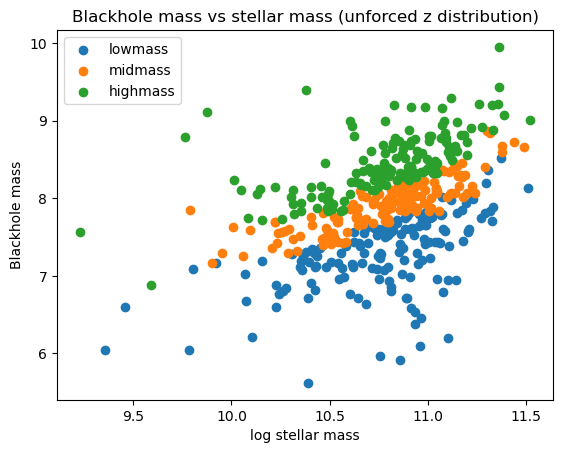

In [31]:
plt.scatter(agnstellarlowmass['log_Ms'],agnstellarlowmass['Mbh'],label='lowmass')
plt.scatter(agnstellarmidmass['log_Ms'],agnstellarmidmass['Mbh'],label="midmass")
plt.scatter(agnstellarhighmass['log_Ms'],agnstellarhighmass['Mbh'],label='highmass')
plt.xlabel('log stellar mass')
plt.ylabel('Blackhole mass')
plt.title('Blackhole mass vs stellar mass (unforced z distribution)')
plt.legend()

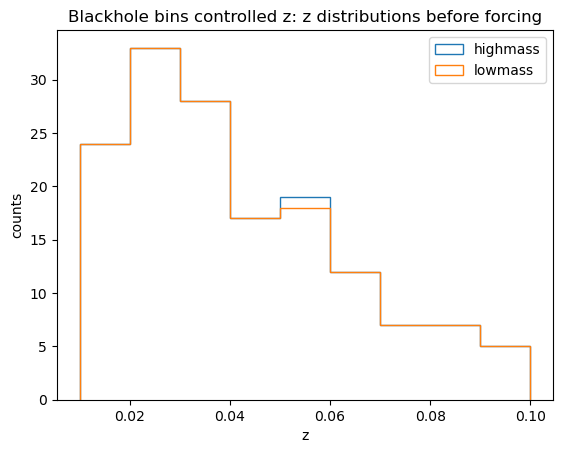

In [22]:
plt.hist(agnhighmass['z'],bins=zbins,histtype='step',label='highmass')
plt.hist(agnlowmass['z'],bins=zbins,histtype='step',label='lowmass')
graph=plt.title('Blackhole bins controlled z: z distributions before forcing')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()

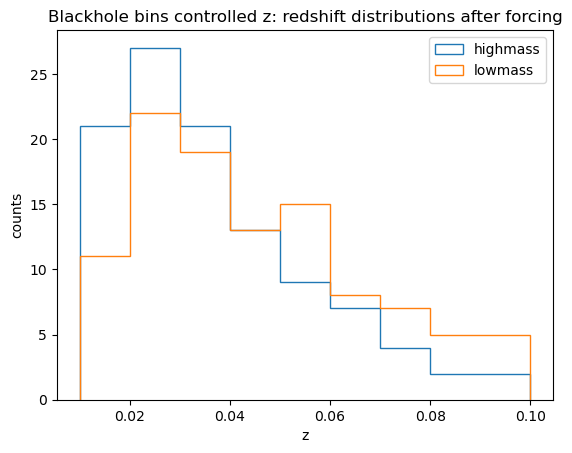

In [24]:
plt.hist(forced_agnhighmass['z'],bins=zbins,histtype='step',label='highmass')
plt.hist(forced_agnlowmass['z'],bins=zbins,histtype='step',label='lowmass')
graph=plt.title('Blackhole bins controlled z: redshift distributions after forcing')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()

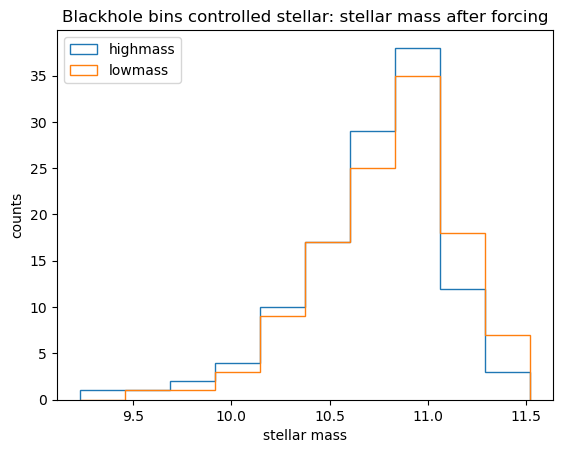

In [26]:
plt.hist(forced_agnstellarhighmass['log_Ms'],bins=msbins,histtype='step',label='highmass')
plt.hist(forced_agnstellarlowmass['log_Ms'],bins=msbins,histtype='step',label='lowmass')
graph=plt.title('Blackhole bins controlled stellar: stellar mass after forcing')
plt.xlabel('stellar mass')
plt.ylabel('counts')
plt.legend()

In [318]:
rp_high,wp_agp_high,wp_agp_err_high,Mag = w.cross_wp(d1=upper, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


In [319]:
rp_low,wp_agp_low,wp_agp_err_low,Mag=w.cross_wp(d1=lower, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........

18 / 25


100% done. Time taken =  0.027 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


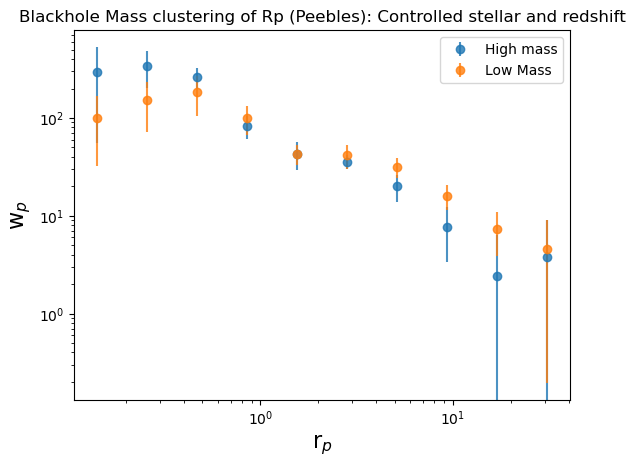

In [320]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp_high,wp_agp_high,yerr=wp_agp_err_high,fmt='o',label='High mass',alpha=0.8)
plt.errorbar(rp_low,wp_agp_low,yerr=wp_agp_err_low,fmt='o',label='Low Mass',alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Blackhole Mass clustering of Rp (Peebles): Controlled stellar and redshift')
plt.legend()


In [252]:
pi_low,pi_p_low,pi_p_err_low,Mag=wz.cross_wppi(d1=lower, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='P')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.067 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.....100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.051 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


In [253]:
pi_high,pi_p_high,pi_p_err_high,Mag=wz.cross_wppi(d1=upper, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='P')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs


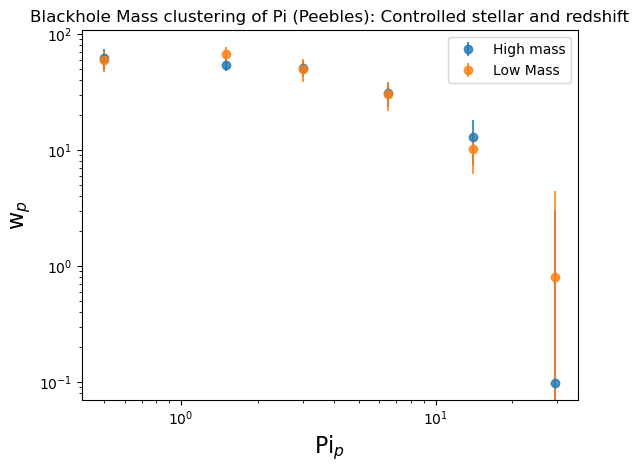

In [265]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(pi_high,pi_p_high,yerr=pi_p_err_high,fmt='o',label='High mass',alpha=0.8)
plt.errorbar(pi_low,pi_p_low,yerr=pi_p_err_low,fmt='o',label='Low Mass',alpha=0.8)
plt.xlabel('Pi$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Blackhole Mass clustering of Pi (Peebles): Controlled stellar and redshift')
plt.legend()


In [255]:
rp_high_mod,wp_agp_high_mod,wp_agp_err_high_mod,Mag = w.cross_wp(d1=upper, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.071 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs


In [256]:
rp_low_mod,wp_agp_low_mod,wp_agp_err_low_mod,Mag=w.cross_wp(d1=lower, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='P')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.061 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


In [257]:
ratio_p_err_high=ratio_error(pi_p_high,wp_agp_high_mod,pi_p_err_high,wp_agp_err_high_mod)
ratio_p_err_low=ratio_error(pi_p_low,wp_agp_low_mod,pi_p_err_low,wp_agp_err_low_mod)

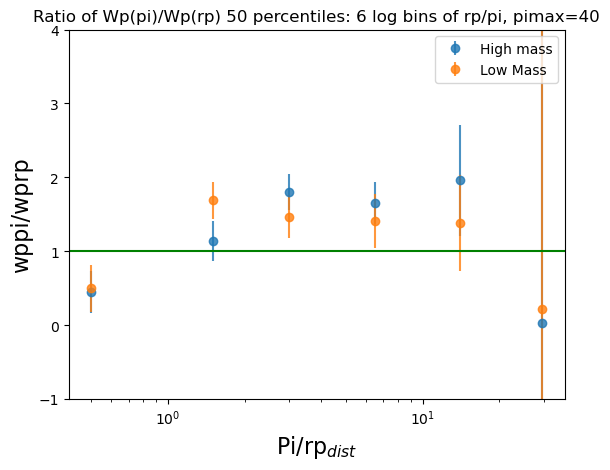

In [267]:
plt.xscale("log")
plt.errorbar(pi_high, pi_p_high/wp_agp_high_mod,yerr=ratio_p_err_high,fmt='o',label='High mass',alpha=0.8)
plt.errorbar(pi_low, pi_p_low/wp_agp_low_mod,yerr=ratio_p_err_low,fmt='o',label='Low Mass',alpha=0.8)
plt.axhline(1,color='g')
plt.ylim([-1,4])
plt.legend()
plt.xlabel('Pi/rp$_{dist}$',fontsize=16)
plt.ylabel('wppi/wprp',fontsize=16)
plt.title('Ratio of Wp(pi)/Wp(rp) 50 percentiles: 6 log bins of rp/pi, pimax=40')k

In [294]:
highmass_subsample=Table()
highmass_subsample=upper
ascii.write(highmass_subsample, 'highmass_subsample(1).csv',format='csv', overwrite=True)

In [295]:
lowmass_subsample=Table()
lowmass_subsample=lower
ascii.write(lowmass_subsample, 'lowmass_subsample(1).csv',format='csv', overwrite=True)

In [20]:
rp_high,wp_ag_high,wp_ag_err_high,Mag = w.cross_wp(d1=agnhighmass, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

In [21]:
rp_low,wp_ag_low,wp_ag_err_low,Mag=w.cross_wp(d1=agnlowmass, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

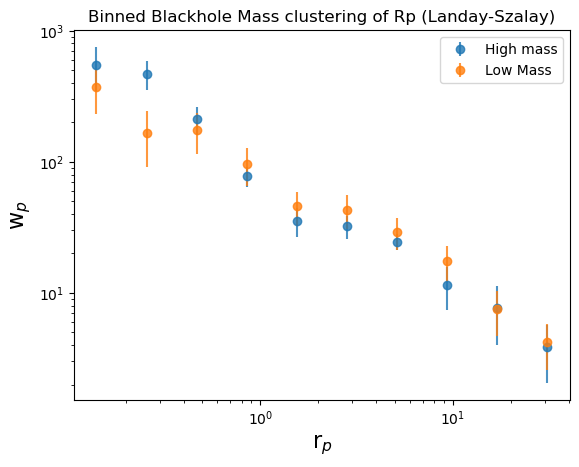

In [22]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp_high,wp_ag_high,yerr=wp_ag_err_high,fmt='o',label='High mass',alpha=0.8)
plt.errorbar(rp_low,wp_ag_low,yerr=wp_ag_err_low,fmt='o',label='Low Mass',alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Binned Blackhole Mass clustering of Rp (Landay-Szalay)')
plt.legend()

In [23]:
pi_low,pi_ls_low,pi_ls_err_low,Mag=wz.cross_wppi(d1=agnlowmass, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

In [24]:
pi_high,pi_ls_high,pi_ls_err_high,Mag=wz.cross_wppi(d1=agnhighmass, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.057 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%........

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

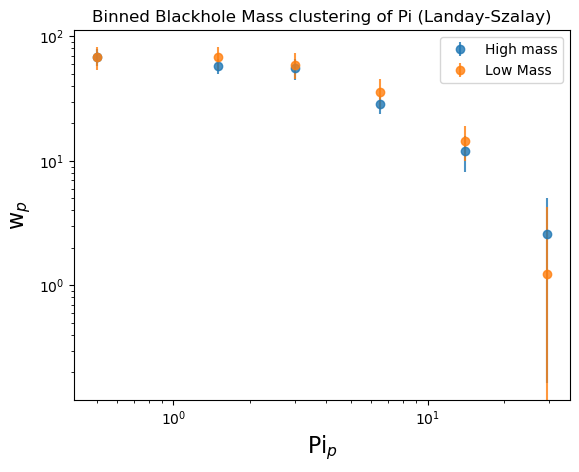

In [25]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(pi_high,pi_ls_high,yerr=pi_ls_err_high,fmt='o',label='High mass',alpha=0.8)
plt.errorbar(pi_low,pi_ls_low,yerr=pi_ls_err_low,fmt='o',label='Low Mass',alpha=0.8)
plt.xlabel('Pi$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Binned Blackhole Mass clustering of Pi (Landay-Szalay)')
plt.legend()

In [39]:
lin_pi_low,lin_pi_ls_low,lin_pi_ls_err_low,Mag=wz.cross_wppi(d1=agnlowmass, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=linpibins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.066 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


In [42]:
lin_pi_high,lin_pi_ls_high,lin_pi_ls_err_high,Mag=wz.cross_wppi(d1=agnhighmass, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=linpibins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.079 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.....100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs


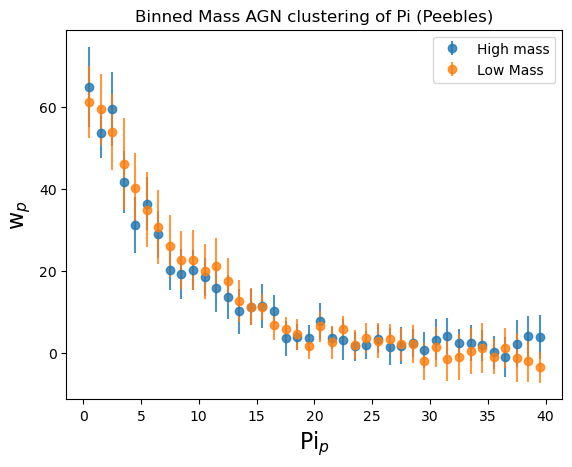

In [45]:
# plt.yscale("log")
# plt.xscale("log")
plt.errorbar(lin_pi_high,lin_pi_ls_high,yerr=lin_pi_ls_err_high,fmt='o',label='High mass',alpha=0.8)
plt.errorbar(lin_pi_low,lin_pi_ls_low,yerr=lin_pi_ls_err_low,fmt='o',label='Low Mass',alpha=0.8)
plt.xlabel('Pi$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Binned Mass AGN clustering of Pi (Peebles)')
plt.legend()

In [91]:
# Code attempting to control for multiple vartiables
hist2d,xedges,yedges,plot=plt.hist2d(agnmass['z'],agnmass['log_Ms'],[zbins,msbins])
print(hist2d)
lower=np.empty(0, dtype=agn.dtype)
mid=np.empty(0,dtype=agn.dtype)
upper=np.empty(0,dtype=agn.dtype)
for i in range (len(hist2d)-1):
    for j in range(len(hist2d[0])-1):
        print(i,':',j)
        print(hist2d[i,j])
        if i == len(hist2d)-1:
            agntemp = (((agnmass[((agnmass['z']<xedges[j+1]) & (agnmass['z']>=xedges[j]) & (agnmass['log_Ms']<=yedges[(i+1)]) & (agnmass['log_Ms']>=yedges[i]))])))
        elif j == len(hist2d)-1:
            agntemp = (((agnmass[((agnmass['z']<=xedges[j+1]) & (agnmass['z']>=xedges[j]) & (agnmass['log_Ms']<yedges[(i+1)]) & (agnmass['log_Ms']>=yedges[i]))])))
        else:
            agntemp = (((agnmass[((agnmass['z']<xedges[j+1]) & (agnmass['z']>=xedges[j]) & (agnmass['log_Ms']<yedges[(i+1)]) & (agnmass['log_Ms']>=yedges[i]))])))
        if hist2d[i,j] == 0 or len(agntemp)==0:
            print('skipped')
        elif hist2d[i,j] == 1:
            if agntemp['Mbh'][0] < np.percentile(agnmass['Mbh'],percentile):
                lower = np.append(lower, agntemp[0])
            elif agntemp['Mbh'][0] > np.percentile(agnmass['Mbh'],100-percentile):
                upper = np.append(upper, agntemp[0])
            else:
                mid = np.append(mid, agntemp[0])
        elif hist2d[i,j] == 2:
            if agntemp['Mbh'][0]>agntemp['Mbh'][1]:
                upper = np.append(upper, agntemp[0])
                lower = np.append(lower, agntemp[1])
            else:
                upper = np.append(upper, agntemp[1])
                lower = np.append(lower, agntemp[0])
        else:
            for k in range(len(agntemp)-1):
                if agntemp['Mbh'][k]<np.percentile(agntemp['Mbh'],(percentile)):
                    lower=np.append(lower,agntemp[k])
                elif agntemp['Mbh'][k]>np.percentile(agntemp['Mbh'],100-percentile):
                    upper=np.append(upper,agntemp[k])
                else:
                    mid=np.append(mid,agntemp[k])
            

In [29]:
rp,wp_agp,wp_agp_err,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.070 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%

9 / 25


.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.113 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.089 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


In [30]:
pi,wppi_p,wppi_p_err,cov = wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.151 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.137 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.151 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.137 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.156 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.144 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.147 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.130 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.123 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.126 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.144 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.144 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.122 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.132 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


In [31]:
ratio_p_err=ratio_error(wppi_p,wp_agp,wppi_p_err,wp_agp_err)

[ 0.5  1.5  3.   6.5 14.  29.5]
[0.47929051 1.39699291 1.77132406 1.59602987 1.42068514 0.11002722]
[0.27435711 0.24542446 0.23012051 0.28656336 0.49685591 6.78545817]


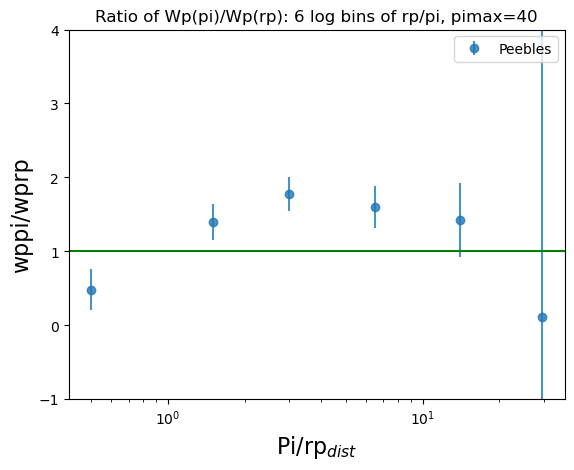

In [33]:
plt.xscale("log")
plt.errorbar(pi, wppi_p/wp_agp,yerr=ratio_p_err,fmt='o',label='Peebles',alpha=0.8)
plt.axhline(1,color='g')
plt.ylim([-1,4])
plt.legend()
plt.xlabel('Pi/rp$_{dist}$',fontsize=16)
plt.ylabel('wppi/wprp',fontsize=16)
plt.title('Ratio of Wp(pi)/Wp(rp): 6 log bins of rp/pi, pimax=40')

print(pi)
print(wppi_p/wp_agp)
print(ratio_p_err)